In [1]:
%pip install -e ..


The following command must be run outside of the IPython shell:

    $ pip install -e ..

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


### Imports

In [2]:
# Import 
import os
import time
import datetime
import numpy as np
from ipywidgets import IntProgress, interact
from IPython.display import display
from pathlib import Path
import ipyvolume as ipv

import matplotlib.pyplot as plt
%matplotlib inline


## The tyssue library provides the core data structures and
## geometry objects
## See https://gihub.com/DamCB/tyssue


from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory 

from tyssue.generation import ellipsoid_sheet
from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.delamination_events import constriction

from tyssue.solvers.quasistatic import QSSolver
from tyssue.geometry.sheet_geometry import EllipsoidGeometry as geom

## The invagination module in this repository provides defintions
## specific to mesoderm invagination

from invagination.ellipsoid import initiate_ellipsoid, define_mesoderm
from invagination.delamination import delamination_process, constriction_rate
from invagination.plots import mesoderm_position
from invagination.ellipsoid import VitellineElasticity, RadialTension


SIM_DIR = Path(os.environ.get('SIM_DIR', ''))
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_smallellipsoid'
try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

## Parameters



In [3]:
specs =  {
    'vert': {
        'height': 0,
        'basal_shift': 0,
        'delta_rho': 30,
        'vitelline_K': 280.0,
        'radial_tension': 0},
    'face': {
        'contractility': 1.12,
        'prefered_area': 22,
        'area_elasticity': 1,
        'surface_tension': 10.
    },
    'edge': {
        'line_tension': 0.0,
    },
    'settings': {
        'abc': [12, 12, 21.0], # Ellipsoid axes
        'geometry': 'cylindrical',
        'height_axis': 'z',
        'vitelline_space': 0.2,
        'threshold_length': 1e-3,
    }
}


## Epithelium generation

`tyssue` provides functions to create epithelium with various base geometries, such as planes or ellipses.

In [4]:
sheet = ellipsoid_sheet(*specs['settings']['abc'], 13)
print(f'The sheet has {sheet.Nf} vertices')
sheet.update_specs(specs)


geom.update_all(sheet)

def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        }
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

The sheet has 184 vertices


/home/guillaume/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

## Quasi-static model for mesoderm invagination


$$E = \sum_\alpha \frac{1}{2}\left(K_A(A - A_0)^2 + \Gamma L_\alpha^2\right) 
     + \sum_i \left(\delta_i R_i h_i + \frac{K_v}{2} r_i^2\right) + \frac{K_Y}{2}(V-V_0)^2$$ 

In [5]:
model = model_factory(
    [
        RadialTension,
        VitellineElasticity,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ])

In [6]:
print('Our model has the following elements :')
print('\t', *model.labels, sep='\n\t')

Our model has the following elements :
	
	Apical basal tension
	Vitelline elasticity
	Contractility
	Area elasticity
	Lumen volume elasticity


In [7]:
# Modify some initial values
sheet.face_df['prefered_area'] = sheet.face_df['area'].mean()
sheet.settings['lumen_prefered_vol'] = 12666
sheet.settings['lumen_vol'] = 11626
sheet.settings['lumen_vol_elasticity'] = 1.0e-3

geom.update_all(sheet)

In [8]:
sheet.settings

{'abc': [12, 12, 21.0],
 'lumen_vol': 11626.557874584283,
 'geometry': 'cylindrical',
 'height_axis': 'z',
 'vitelline_space': 0.2,
 'threshold_length': 0.001,
 'lumen_prefered_vol': 12666,
 'lumen_vol_elasticity': 0.001}

### Gradient descent

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


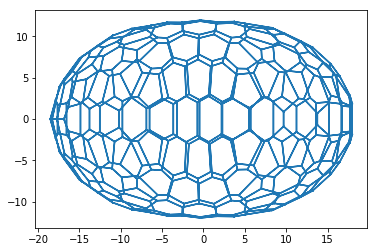

In [9]:
solver_kw = {
    'method': 'L-BFGS-B',
    'options': {'ftol': 1e-8,
                'gtol': 1e-8}
}

solver = QSSolver()
res = solver.find_energy_min(sheet, geom, model, **solver_kw)

print(res.message)
fig, ax = sheet_view(sheet, coords=list('zx'), mode='quick')

In [10]:
ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))

ipv_fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

number of apoptotic cells: 26


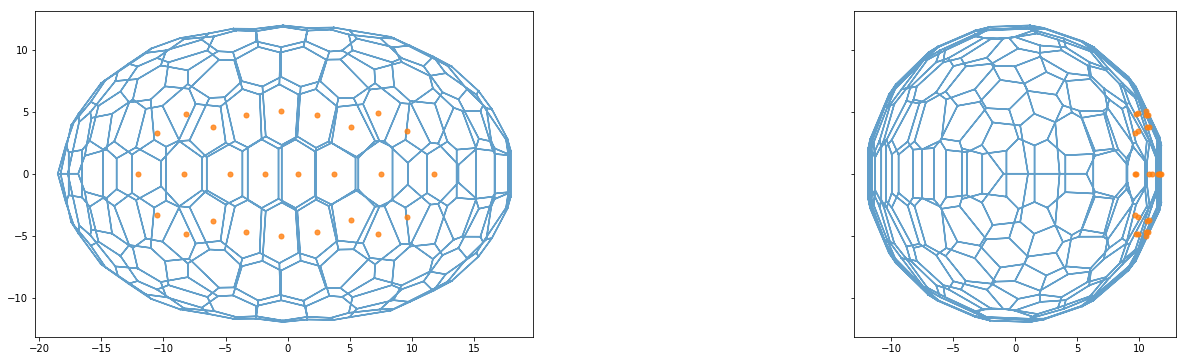

In [11]:
# Define ovoid mesoderm
define_mesoderm(sheet, a=15, b=6.)

mesoderm = sheet.face_df[sheet.face_df.is_mesoderm].index
delaminating_cells = sheet.face_df[sheet.face_df['is_mesoderm']].index
sheet.face_df['is_relaxation'] = False
print('number of apoptotic cells: {}'.format(delaminating_cells.size))
fig, axes = mesoderm_position(sheet, delaminating_cells)

In [12]:
progress = IntProgress(min=0)


def run_sim(sheet, mesoderm, geom, model, dirname, progress, stop=15):
    progress.max = stop
   
    display(progress)
    delaminating_cells = []
    #Initiate manager
    manager = EventManager('face', logfile='manager_log.txt')
    sheet.face_df['enter_in_process'] = 0
    
    # Add all cells in constriction process 
    for f in sheet.face_df[sheet.face_df['is_mesoderm']].index :
        x = sheet.face_df.loc[f, 'x']
        c_rate = constriction_rate(x, max_constriction_rate=1.32, k=0.19, w=25)

        delam_kwargs = sheet.settings["delamination"].copy()
        delam_kwargs.update(
            {
                'face_id':f,
                'contract_rate': c_rate,
                'current_traction': 0,
                'max_traction':30
            }
        )
        manager.append(constriction, **delam_kwargs)
    
    while manager.current and manager.clock < stop:

        # Clean radial tension on all vertices
        sheet.vert_df['radial_tension'] = 0
        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, **solver_kw)
        
        # Save result at each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(manager.clock))
        hdfname = figname[:-3] + 'hf5'
        hdf5.save_datasets(hdfname, sheet)

        manager.update()
        manager.clock += 1
        progress.value = manager.clock
    
    progress.stop = manager.clock
    return sheet

## Simulation of the invagination

Take a few minutes

In [13]:

contractility_rate = 2
critical_area = 5
radial_tension = 40

# Directory definition 
dirname = '{}_contractility_{}_critical_area_{}_radialtension'.format(
            contractility_rate, critical_area, radial_tension)
dirname = sim_save_dir/dirname

print('starting {}'.format(dirname))
try:
    os.mkdir(dirname)
except IOError:
    pass

settings = {'contract_rate': contractility_rate,
            'critical_area': critical_area,
            'radial_tension': radial_tension,
            'nb_iteration': 10,
            'contract_neighbors':True,
            'contract_span':1,
            'geom': geom}


# Add some information to the sheet
sheet.face_df['id'] = sheet.face_df.index.values
sheet.settings['delamination'] = settings

sheet = run_sim(sheet, delaminating_cells, 
                 geom, model, dirname, progress)

print('{} done'.format(dirname))
print('~~~~~~~~~~~~~~~~~~~~~\n')
    

starting 2019-06-18_smallellipsoid/2_contractility_5_critical_area_40_radialtension


IntProgress(value=0, max=15)

2019-06-18_smallellipsoid/2_contractility_5_critical_area_40_radialtension done
~~~~~~~~~~~~~~~~~~~~~



### 3D viewer of the invagination process


In [14]:
hfs = [f  for f in os.listdir(dirname) if f.endswith('hf5')]
hfs.sort()
from tyssue.draw.ipv_draw import edge_mesh, face_mesh

def get_meshes(dirname, hdf_file):
    dsets = hdf5.load_datasets(os.path.join(dirname, hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
    sheet = Sheet('ellipse', dsets)
    faces = face_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.face_df['area'],
                      color_range=(0, 30))
    
    edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.vert_df.y)
    return faces, edges

def browse_sheets(dirname, hfs):
    n = len(hfs)
    ipv.clear()
    fig = ipv.gcf()
    meshes = get_meshes(dirname, hfs[0])
    fig.meshes = fig.meshes + list(meshes)
    
    def view_sheet(i):
        fig.animation = 0

        faces, edges = get_meshes(dirname, hfs[i])
        fig.meshes[0].x = faces.x
        fig.meshes[0].y = faces.y
        fig.meshes[0].z = faces.z
        fig.meshes[0].color = faces.color
        fig.meshes[0].triangles = faces.triangles

        fig.meshes[1].x = edges.x
        fig.meshes[1].y = edges.y
        fig.meshes[1].z = edges.z
        fig.meshes[1].color = edges.color
        fig.meshes[1].lines = edges.lines

        lim_inf = sheet.vert_df[sheet.coords].min().min()
        lim_sup = sheet.vert_df[sheet.coords].max().max()
        ipv.xyzlim(lim_inf, lim_sup)
    ipv.show()
    interact(view_sheet, i=(0, n-1))


In [15]:
browse_sheets(dirname, hfs)

/home/guillaume/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…